In [1]:
#import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import scipy
from scipy.linalg import logm
from scipy.optimize import minimize
import networkx as nx
import seaborn
import itertools
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import *

%matplotlib inline

np.random.seed(42)

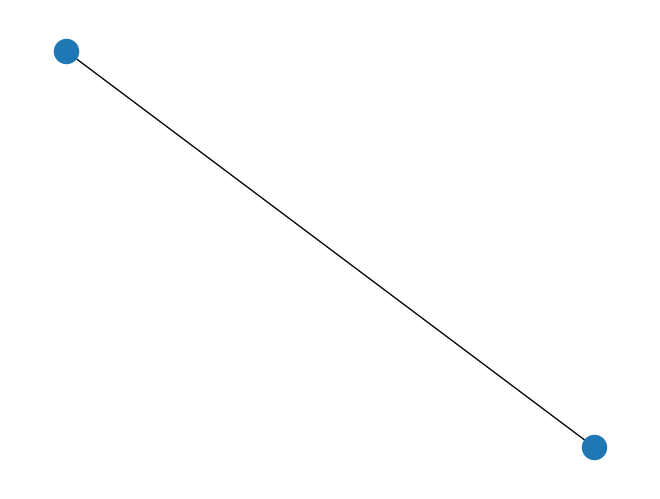

In [2]:
interaction_graph = nx.cycle_graph(2)
nx.draw(interaction_graph)

# VQT
* Definindo o hamiltonaino

In [3]:

ham_matrix = array([[ 0.25,  0,  0,  0  ],
       [ 0, -0.25,  0.5 ,  0],
       [ 0,  0.5, -0.25,  0],
       [ 0,  0,  0,  0.25]])

In [4]:
ham_matrix

array([[ 0.25,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.25,  0.5 ,  0.  ],
       [ 0.  ,  0.5 , -0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.25]])

* Criando o  ansatz

In [4]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T

def single_rotation(circuit, phi_params, qubits):
    rotations = ["Z", "Y", "X"]
    for i, rot in enumerate(rotations):
        for qubit in qubits:
            if rot == "Z":
                circuit.rz(phi_params[i][qubit], qubit)
            elif rot == "Y":
                circuit.ry(phi_params[i][qubit], qubit)
            elif rot == "X":
                circuit.rx(phi_params[i][qubit], qubit)

def quantum_circuit(rotation_params, coupling_params, sample=None):
    nr_qubits = 2
    depth = 2
    circuit = QuantumCircuit(nr_qubits)

    if sample is not None:
        for i, bit in enumerate(sample):
            if bit == 1:
                circuit.x(i)

    for i in range(depth):
        single_rotation(circuit, rotation_params[i], range(nr_qubits))
        for j in range(nr_qubits - 1):
            circuit.crx(coupling_params[i][j], j, j + 1)

    return circuit

In [5]:
backend = FakeSherbrooke()

def measure_zz(given_circuit, num_shots=9000):

    zz_meas = given_circuit.copy()
    zz_meas.measure_all()
    
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    
    transpile = pm.run(zz_meas)
    
    counts = backend.run(transpile, shots=num_shots).result().get_counts()
    
    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
    zz = counts['00'] - counts['01'] - counts['10'] + counts['11']
    zz = zz / total_counts
    
    return zz

In [6]:
def measure_xx(given_circuit, num_shots =9000):

    xx_meas = given_circuit.copy()
    xx_meas.h(0)
    xx_meas.h(1)
    xx_meas.measure_all()
    
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    
    transpile = pm.run(xx_meas)
    
    counts = backend.run(transpile, shots=num_shots).result().get_counts()

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
    xx = counts['00'] - counts['01'] - counts['10'] + counts['11']
    xx = xx / total_counts
    
    return xx

In [7]:
def measure_yy(given_circuit, num_shots = 9000):

    yy_meas = given_circuit.copy()
    yy_meas.rx(-np.pi/2, 0)
    yy_meas.rx(-np.pi/2, 1)
    yy_meas.measure_all()
    
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    
    transpile = pm.run(yy_meas)
    
    counts = backend.run(transpile, shots=num_shots).result().get_counts()

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['01'] + counts['10'] + counts['11']
    yy = counts['00'] - counts['01'] - counts['10'] + counts['11']
    yy = yy / total_counts
    
    return yy

* Calculando a entropia e defindo função auxíliar para lidar com formato da lista que é passada para o ansatz

In [8]:
def calculate_entropy(distribution):

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

    # Returns an array of the entropy values of the different initial density matrices

    return total_entropy

def convert_list(params):

    # Separates the list of parameters
    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)

    # Partitions the parameters into multiple lists
    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]

* Cálculo do custo

In [9]:


def exact_cost(params):

    global iterations, beta
    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        qc = quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i)
    
        zz = measure_zz(quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i))
        xx = measure_xx(quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i))
        yy = measure_yy(quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i))
        
        result = 0.25*zz + 0.25*xx + 0.25*yy
        
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    # Calculates the entropy and the final cost function
    entropy = calculate_entropy(distribution)
    final_cost = beta* cost - entropy

    final_cost_scalar = final_cost 

    return final_cost_scalar

def cost_execution(params):

    global iterations

    cost = exact_cost(params)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

In [10]:
#Teste
nr_qubits = 2
depth = 2
number = nr_qubits * (1 + depth * 4)
params = [np.random.randint(-300, 300) / 100 for i in range(0, int(number))]
params = np.array(params)
res = convert_list(params)


In [11]:
Temp = np.logspace(np.log10(0.0005),np.log10(20),80)
len(Temp)

80

* Otimização

In [12]:
beta_values = 1.67/Temp
iterations = 0
out_params_dict = {}
for beta in beta_values:
    out = minimize(cost_execution, x0=params, method="COBYLA", options={"maxiter": 400})
    out_params = out["x"]
    out_params_dict[beta] = out_params

Cost at Step 0: 357.109039522872
Cost at Step 50: -1412.2634479309
Cost at Step 100: -1824.900254273747
Cost at Step 150: -1889.4061108049434
Cost at Step 200: -1880.8960354972019
Cost at Step 250: -821.1242126905112
Cost at Step 300: -1492.289958561609
Cost at Step 350: -1511.1864717121337
Cost at Step 400: -1506.7817362487447
Cost at Step 450: -637.393765749371
Cost at Step 500: -1301.0710794249062
Cost at Step 550: -1395.9324408020698
Cost at Step 600: -1394.82499075475
Cost at Step 650: -1394.138731191292
Cost at Step 700: -1071.943136078283
Cost at Step 750: -1233.9857951042954
Cost at Step 800: -1266.7900468076346
Cost at Step 850: -1264.78302466969
Cost at Step 900: -587.81373670028
Cost at Step 950: -1039.4831943290299
Cost at Step 1000: -1069.2933937618743
Cost at Step 1050: -1060.2790823535668
Cost at Step 1100: -430.3403771030833
Cost at Step 1150: -830.8942159828737
Cost at Step 1200: -899.8959560371835
Cost at Step 1250: -900.3475541619213
Cost at Step 1300: -895.923824427

In [13]:
#Preparando estado
def prepare_state(params):

    # Initialies the density matrix

    final_density_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))

    # Prepares the optimal parameters, creates the distribution and the bitstrings
    parameters = convert_list(params)
    dist_params = parameters[0]
    unitary_params = parameters[1]

    distribution = prob_dist(dist_params)

    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Runs the circuit in the case of the optimal parameters, for each bitstring,
    # and adds the result to the final density matrix

    for i in s:
        qc = quantum_circuit(unitary_params[0], unitary_params[1], sample=i)
        state = Statevector.from_instruction(qc)
        state_vector = state.data
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]]) * state
        final_density_matrix = np.add(final_density_matrix, np.outer(state, np.conj(state)))

    return final_density_matrix

# Prepares the density matri

density_matrix_dict = {}

for beta, out_params in out_params_dict.items():
    # Calcula a matriz densidade para cada valor de beta usando os out_params correspondentes
    prep_density_matrix = prepare_state(out_params)
    prep_density_matrix  = np.real(prep_density_matrix )

    # Armazena a matriz densidade no dicionário usando o valor de beta como chave

    density_matrix_dict[beta] = prep_density_matrix

## Cálculo das propriedades termodinâmicas

In [14]:
#Filtro do elemento a11 das matrizes e susceptibilidade 
S = []
Chi = []
A   = [] 
for beta, density_matrix in density_matrix_dict.items():
    #Entropia
    rho = np.real(density_matrix_dict[beta])
    s = -np.trace(rho@logm(rho))
    S.append(s)
    #Susceptibilidade 
    a_11 = density_matrix[0, 0] 
    A.append(a_11)
    chi = 4*a_11
    Chi.append(chi)

In [16]:
df = pd.DataFrame({"Temp": Temp, "S":S, "Chi": Chi})
df.to_csv('Noise167.csv', index=False)

In [17]:
pd.set_option('display.max_rows', None)
df

,Temp,S,Chi
0,0.000500,0.344982,0.068132
1,0.000572,0.511405,0.107331
2,0.000654,0.408495,0.082698
3,0.000748,0.336610,0.108602
4,0.000855,0.447960,0.156284
5,0.000978,0.492159,0.103425
6,0.001118,0.471153,0.127594
7,0.001279,0.401705,0.079626
8,0.001462,0.349934,0.138867
9,0.001672,0.440490,0.161344
